# Switched Bouncing Ball

This example demonstrates advanced event handling with multiple simultaneous events, event switching, and conditional event logic. The bouncing ball bounces on a table first, and then drops to the floor and continues to bounce there.

You can also find this example as a single file in the [GitHub repository](https://github.com/milanofthe/pathsim/blob/master/examples/examples_event/example_bouncingball_switched.py).

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Apply PathSim docs matplotlib style
plt.style.use('../pathsim_docs.mplstyle')

from pathsim import Simulation, Connection
from pathsim.blocks import Integrator, Constant, Function, Adder, Scope
from pathsim.solvers import RKBS32
from pathsim.events import ZeroCrossing, Condition

## System Dynamics

The ball experiences:
1. Gravitational acceleration downward
2. Quadratic air resistance (Newton's drag law)
3. Elastic bounces at $x = 0$ (floor) and $x = -5$ (ceiling)

The equation of motion is:

$$\ddot{x} = -g - k \cdot \text{sign}(v) \cdot v^2$$

where $k$ is the mass-normalized friction coefficient.

In [5]:
# Simulation timestep
dt = 0.01

# Gravitational acceleration
g = 9.81

# Elasticity of bounce
b = 0.95

# Mass normalized friction coefficient
k = 0.2

# Initial values
x0, v0 = 1, 10

## Block Diagram Construction

In [8]:
# Newton friction (quadratic drag)
def fric(v):
    return -k * np.sign(v) * v**2

# Blocks that define the system
Ix = Integrator(x0)     # v -> x
Iv = Integrator(v0)     # a -> v
Fr = Function(fric)     # newton friction
Ad = Adder()
Cn = Constant(-g)       # gravitational acceleration
Sc = Scope(labels=["x", "v"])

blocks = [Ix, Iv, Fr, Ad, Cn, Sc]

# The connections between the blocks
connections = [
    Connection(Cn, Ad[0]),
    Connection(Fr, Ad[1]),
    Connection(Ad, Iv),
    Connection(Iv, Ix, Fr),
    Connection(Ix, Sc[0])
]

In [10]:
# Event 1: Table bounce (x = 0)
def func_evt_1(t):
    *_, x = Ix()
    return x

def func_act_1(t):
    *_, x = Ix()
    *_, v = Iv()
    Ix.engine.set(abs(x))
    Iv.engine.set(-b*v)

E1 = ZeroCrossing(
    func_evt=func_evt_1,
    func_act=func_act_1,
    tolerance=1e-4
)

In [12]:
# Event 2: Floor bounce (x = -5)
def func_evt_2(t):
    *_, x = Ix()
    return x + 5

def func_act_2(t):
    *_, x = Ix()
    *_, v = Iv()
    Ix.engine.set(abs(x + 5) - 5)
    Iv.engine.set(-b*v)

E2 = ZeroCrossing(
    func_evt=func_evt_2,
    func_act=func_act_2,
    tolerance=1e-4
)

In [14]:
# Event 3: Conditional switch after 10 table bounces
E3 = Condition(
    func_evt=lambda *_: len(E1) >= 10,        # number of events 'E1' (bounces)
    func_act=lambda *_: [E1.off(), E3.off()]  # callback switches event tracking
)

The condition event checks if the table bounce event `E1` has occurred 10 times. When this happens, it:
1. Disables table bounce tracking with `E1.off()`
2. Disables itself with `E3.off()`

After this point, only the flfoor bounce `E2` remains active.

In [17]:
# Initialize simulation
Sim = Simulation(
    blocks,
    connections,
    events=[E1, E2, E3],
    dt=dt,
    log=True,
    Solver=RKBS32,
    tolerance_lte_abs=1e-6,
    tolerance_lte_rel=1e-4
)

2025-10-10 14:18:35,932 - INFO - LOGGING (log: True)
2025-10-10 14:18:35,932 - INFO - BLOCK (type: Integrator, dynamic: True, events: 0)
2025-10-10 14:18:35,933 - INFO - BLOCK (type: Integrator, dynamic: True, events: 0)
2025-10-10 14:18:35,933 - INFO - BLOCK (type: Function, dynamic: False, events: 0)
2025-10-10 14:18:35,934 - INFO - BLOCK (type: Adder, dynamic: False, events: 0)
2025-10-10 14:18:35,934 - INFO - BLOCK (type: Constant, dynamic: False, events: 0)
2025-10-10 14:18:35,934 - INFO - BLOCK (type: Scope, dynamic: False, events: 0)
2025-10-10 14:18:35,935 - INFO - GRAPH (size: 6, alg. depth: 3, loop depth: 0, runtime: 0.080ms)


Now let's run the simulation:

In [20]:
# Run the simulation
Sim.run(15)

2025-10-10 14:18:38,426 - INFO - STARTING -> TRANSIENT (Duration: 15.00s)
2025-10-10 14:18:38,426 - INFO - TRANSIENT:   0% | elapsed: 00:00:00 (eta: --:--:--) | 0 steps (N/A steps/s)
2025-10-10 14:18:38,444 - INFO - TRANSIENT:  20% | elapsed: 00:00:00 (eta: --:--:--) | 115 steps (6148.9 steps/s)
2025-10-10 14:18:38,475 - INFO - TRANSIENT:  40% | elapsed: 00:00:00 (eta: --:--:--) | 314 steps (6594.1 steps/s)
2025-10-10 14:18:38,496 - INFO - TRANSIENT:  60% | elapsed: 00:00:00 (eta: --:--:--) | 467 steps (7231.8 steps/s)
2025-10-10 14:18:38,516 - INFO - TRANSIENT:  80% | elapsed: 00:00:00 (eta: --:--:--) | 615 steps (7508.7 steps/s)
2025-10-10 14:18:38,548 - INFO - TRANSIENT: 100% | elapsed: 00:00:00 (eta: 00:00:00) | 862 steps (7666.2 steps/s)
2025-10-10 14:18:38,548 - INFO - TRANSIENT: 100% | elapsed: 00:00:00 (eta: 00:00:00) | 862 steps (7013.3 avg steps/s)
2025-10-10 14:18:38,549 - INFO - FINISHED -> TRANSIENT (total steps: 862, successful: 595, runtime: 122.91 ms)


{'total_steps': 862, 'successful_steps': 595, 'runtime_ms': 122.907099997974}

## Results

Let's plot the results with all three event types marked differently:

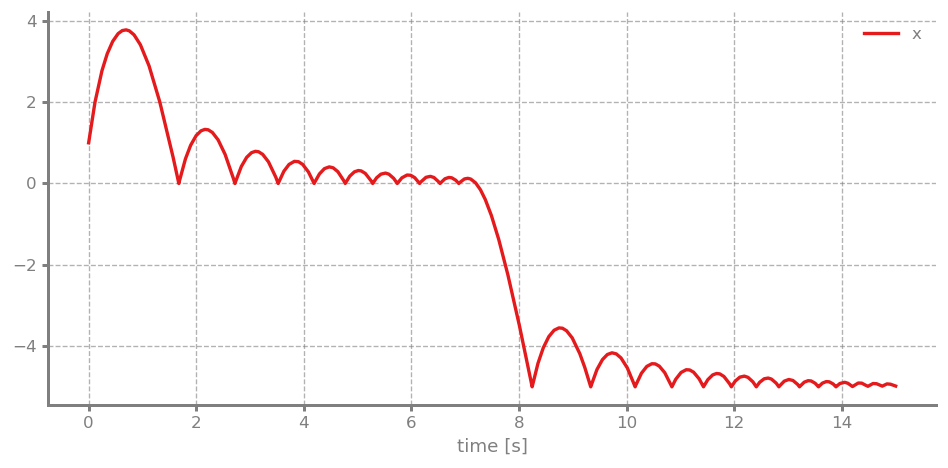

In [23]:
# Plot the recordings from the scope
time, [x] = Sc.read()

fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(time, x)

# Add detected events to scope plot with different styles
for t in E1:
    ax.axvline(t, ls="--", c="gray", alpha=0.5, label="Floor bounce" if t == list(E1)[0] else "")
    
for t in E2:
    ax.axvline(t, ls="-.", c="gray", alpha=0.5, label="Ceiling bounce" if t == list(E2)[0] else "")
    
for t in E3:
    ax.axvline(t, ls="-", c="gray", lw=2, alpha=0.7, label="Switch event")

ax.legend()
plt.show()

## Analysis

The plot reveals several interesting behaviors:

1. **Initial phase**: The ball bounces on the table floor ($x = 0$, dashed lines)
2. **Switch event**: After 10 table bounces, the conditional event triggers (solid vertical line)
3. **Post-switch phase**: Table bounces are no longer detected, so the ball passes through the table and falls to the floor where it continues to bounce
4. **Energy dissipation**: Due to air resistance, the amplitude decreases over time

This demonstrates how event logic can dynamically change system behavior during simulation, useful for:
- Mode switching in control systems
- Modeling wear or failure after a certain number of cycles
- Implementing complex state machines

## Event Counts

We can also check how many times each event occurred:

In [30]:
print(f"Table bounces (E1): {len(E1)}")
print(f"Floor bounces (E2): {len(E2)}")
print(f"Switch events (E3): {len(E3)}")

Floor bounces (E1): 10
Ceiling bounces (E2): 15
Switch events (E3): 1


As expected, `E1` should have exactly 10 events (the trigger condition), `E3` should have 1 event (when it disabled itself), and `E2` will vary depending on the system dynamics.